In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation, SegformerConfig
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model Setup ---
NUM_CLASSES = 3

# Load SegFormer
segformer_config = SegformerConfig.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label={0: "background", 1: "crack", 2: "pothole"},
    label2id={"background": 0, "crack": 1, "pothole": 2}
)

segformer = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    config=segformer_config,
    ignore_mismatched_sizes=True
)
segformer.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\segformer_last.pth", map_location=device))
segformer.to(device).eval()

# Load UNet
unet = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES
)
unet.load_state_dict(torch.load(r"C:\Users\SHREY\Desktop\gnctd\last_model.pth", map_location=device))
unet.to(device).eval()

# --- Preprocessing functions ---

def preprocess_unet_image(img_path):
    image = Image.open(img_path).convert("RGB")
    w, h = image.size
    if h < 640:
        pad_h = 640 - h
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        image = transforms.functional.pad(image, (0, pad_top, 0, pad_bottom), fill=0)
    tensor = transforms.functional.to_tensor(image)
    return tensor.unsqueeze(0)  # shape: (1, 3, H, W)

def preprocess_segformer_image(img_path):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),  # only ToTensor, no normalization
    ])
    return transform(image).unsqueeze(0)  # shape: (1, 3, 512, 512)

# --- Inference ---

@torch.no_grad()
def ensemble_predict(img_path):
    # Preprocess inputs
    img_unet = preprocess_unet_image(img_path).to(device)         # (1, 3, 640, 1024)
    img_segformer = preprocess_segformer_image(img_path).to(device)  # (1, 3, 512, 512)

    # --- Inference ---
    out_unet = unet(img_unet)  # logits (1, 3, 640, 1024)
    prob_unet = F.softmax(out_unet, dim=1)

    out_segformer = segformer(pixel_values=img_segformer).logits  # logits (1, 3, 512, 512)
    out_segformer = F.interpolate(out_segformer, size=(640, 1024), mode="bilinear", align_corners=False)
    prob_segformer = F.softmax(out_segformer, dim=1)

    # --- Bagging ---
    avg_prob = (prob_unet + prob_segformer) / 2
    pred_mask = torch.argmax(avg_prob, dim=1)  # (1, 640, 1024)

    return pred_mask.squeeze(0).cpu().numpy()  # numpy array of class indices

# Example usage
# mask = ensemble_predict(r"C:\path\to\image.jpg")
# plt.imshow(mask, cmap='tab10')

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\SHREY\AppData\Local\Temp\ipykernel_21820\1743730587.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). 

In [2]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torchvision.transforms as transforms

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Preprocessing functions (reuse from ensemble_predict)
def preprocess_unet_image_pil(pil_img):
    w, h = pil_img.size
    if h < 640:
        pad_h = 640 - h
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pil_img = transforms.functional.pad(pil_img, (0, pad_top, 0, pad_bottom), fill=0)
    tensor = transforms.functional.to_tensor(pil_img)
    return tensor.unsqueeze(0)

def preprocess_segformer_image_pil(pil_img):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    return transform(pil_img).unsqueeze(0)

# --- Ensemble inference for batch
@torch.no_grad()
def ensemble_metrics_eval(dataloader, unet, segformer):
    unet.eval()
    segformer.eval()

    all_preds = []
    all_labels = []

    for images, masks in tqdm(dataloader, desc="🔍 Evaluating Ensemble", leave=False):
        for i in range(images.shape[0]):
            pil_img = transforms.ToPILImage()(images[i].cpu())
            mask = masks[i].cpu().numpy()

            # UNet
            img_unet = preprocess_unet_image_pil(pil_img).to(device)
            out_unet = unet(img_unet)
            prob_unet = torch.nn.functional.softmax(out_unet, dim=1)

            # SegFormer
            img_segformer = preprocess_segformer_image_pil(pil_img).to(device)
            out_segformer = segformer(pixel_values=img_segformer).logits
            out_segformer = torch.nn.functional.interpolate(out_segformer, size=(640, 1024), mode='bilinear', align_corners=False)
            prob_segformer = torch.nn.functional.softmax(out_segformer, dim=1)

            # Average
            avg_prob = (prob_unet + prob_segformer) / 2
            pred_mask = torch.argmax(avg_prob, dim=1).squeeze(0).cpu().numpy()

            all_preds.extend(pred_mask.flatten())
            all_labels.extend(mask.flatten())

    # --- Metrics ---
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))

    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Ensemble Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # --- Confusion Matrix ---
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("\n📋 Standardized Confusion Matrix (rows sum to 1):")
    for i, row in enumerate(cm_normalized):
        row_str = '  '.join(f"{val:.4f}" for val in row)
        print(f"{CLASS_NAMES[i]:<10}: {row_str}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Standardized Confusion Matrix (Ensemble)")
    plt.tight_layout()
    plt.show()

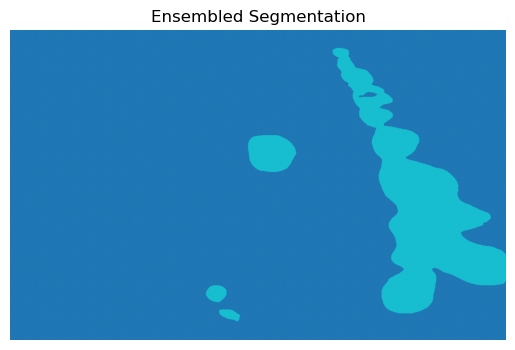

In [5]:
image_path = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\test\images\883254_RS_290_290RS150131_17000.jpg"

mask = ensemble_predict(image_path)

# Optional: visualize
import matplotlib.pyplot as plt
plt.imshow(mask, cmap="tab10")
plt.title("Ensembled Segmentation")
plt.axis("off")
plt.show()

In [6]:
import os
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch
import torchvision.transforms.functional as TF

# Redefining your class since no import is needed
class PaddedSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.filenames = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.images_dir, fname)
        mask_path = os.path.join(self.masks_dir, os.path.splitext(fname)[0] + ".png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        target_h, target_w = 640, 1024
        w, h = image.size

        if h < target_h:
            pad_h = target_h - h
            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            padding = (0, pad_top, 0, pad_bottom)
            image = TF.pad(image, padding, fill=0)
            mask = TF.pad(mask, padding, fill=0)

        image_tensor = TF.to_tensor(image)

        mask_np = np.array(mask, dtype=np.uint8)
        mask_np = np.where(mask_np == 255, 2, np.where(mask_np == 127, 1, 0))
        mask_tensor = torch.from_numpy(mask_np).long()

        return image_tensor, mask_tensor

# Path setup
test_dataset = PaddedSegmentationDataset(
    images_dir=r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\test\images",
    masks_dir=r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\test\masks"
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)


📊 Ensemble Performance Metrics:
Pixel Accuracy: 0.9870
Per-class Accuracy:
  Background: 0.9893
  Crack: 0.8388
  Pothole: 0.7738
IoU per class:
  Background: 0.9871
  Crack: 0.3925
  Pothole: 0.6689
Mean IoU: 0.6829

📋 Standardized Confusion Matrix (rows sum to 1):
Background: 0.9893  0.0100  0.0007
Crack     : 0.1596  0.8388  0.0016
Pothole   : 0.1689  0.0573  0.7738


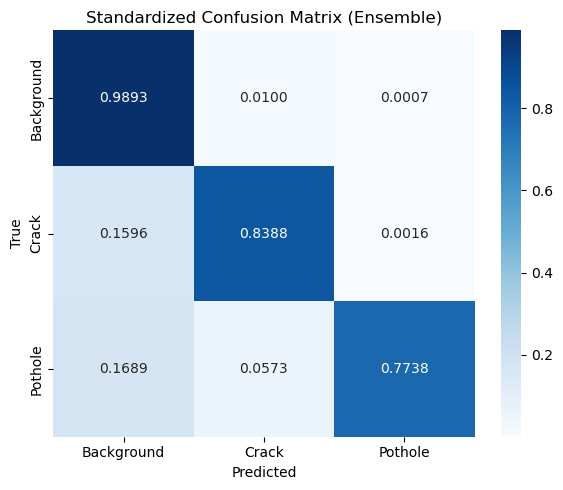

In [8]:
ensemble_metrics_eval(test_loader, unet, segformer)

In [9]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def ensemble_majority_voting_eval(dataloader, unet, segformer, visualize=False, num_visuals=3):
    unet.eval()
    segformer.eval()

    all_preds = []
    all_labels = []
    visual_count = 0

    for images, masks in tqdm(dataloader, desc="🔍 Evaluating Majority Voting", leave=False):
        images, masks = images.to(device), masks.to(device)

        for i in range(images.shape[0]):
            image = images[i].unsqueeze(0)  # shape: (1, 3, H, W)
            mask = masks[i].cpu().numpy()

            # --- UNet inference ---
            out_unet = unet(image)
            prob_unet = F.softmax(out_unet, dim=1)
            pred_unet = torch.argmax(prob_unet, dim=1)

            # --- SegFormer inference ---
            resized_image = F.interpolate(image, size=(512, 512), mode="bilinear", align_corners=False)
            out_segformer = segformer(pixel_values=resized_image).logits
            out_segformer = F.interpolate(out_segformer, size=image.shape[-2:], mode="bilinear", align_corners=False)
            prob_segformer = F.softmax(out_segformer, dim=1)
            pred_segformer = torch.argmax(prob_segformer, dim=1)

            # --- Majority Voting ---
            stacked_preds = torch.stack([pred_unet, pred_segformer], dim=0)
            voted_pred, _ = torch.mode(stacked_preds, dim=0)  # shape: (H, W)
            pred_mask = voted_pred.squeeze(0).cpu().numpy()

            all_preds.extend(pred_mask.flatten())
            all_labels.extend(mask.flatten())

            # Optional visualization
            if visualize and visual_count < num_visuals:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image.squeeze().permute(1, 2, 0).cpu())
                plt.title("Input Image")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
                plt.title("Ground Truth")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
                plt.title("Voted Prediction")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
                visual_count += 1

    # --- Metrics ---
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))

    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Majority Voting Ensemble Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # --- Confusion Matrix ---
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("\n📋 Standardized Confusion Matrix (rows sum to 1):")
    for i, row in enumerate(cm_normalized):
        row_str = '  '.join(f"{val:.4f}" for val in row)
        print(f"{CLASS_NAMES[i]:<10}: {row_str}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Majority Voting")
    plt.tight_layout()
    plt.show()

🔍 Evaluating Majority Voting:   0%|                                                            | 0/28 [00:00<?, ?it/s]

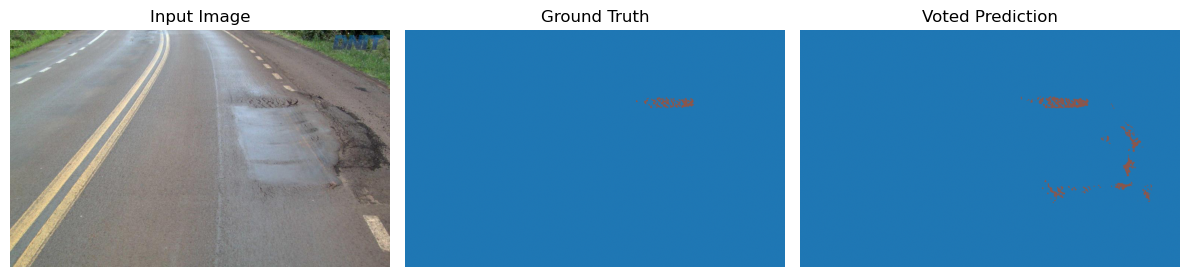

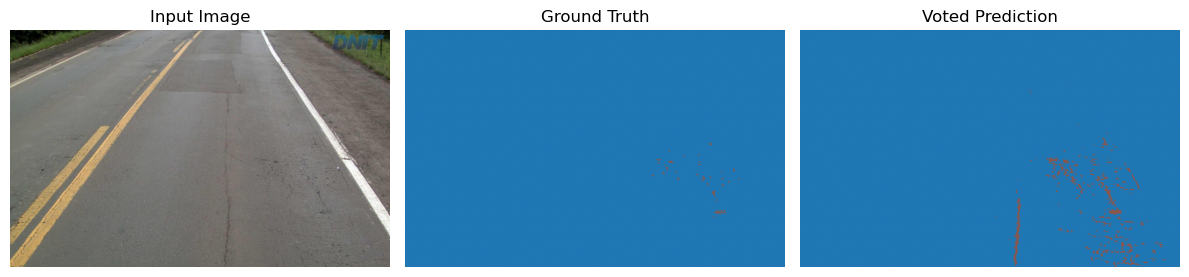

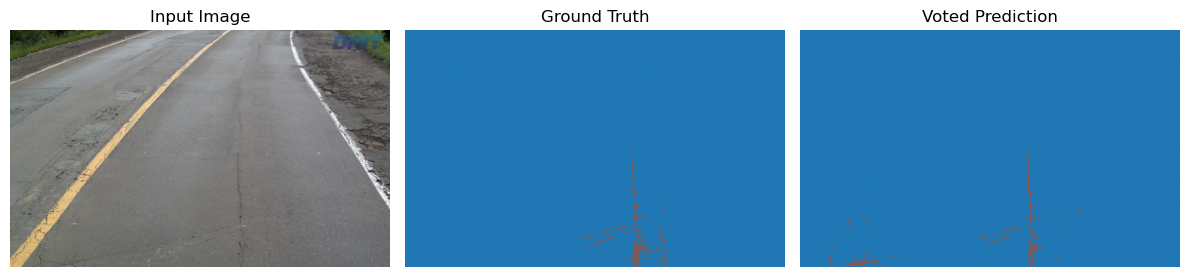


📊 Majority Voting Ensemble Metrics:
Pixel Accuracy: 0.9896
Per-class Accuracy:
  Background: 0.9932
  Crack: 0.7619
  Pothole: 0.6358
IoU per class:
  Background: 0.9899
  Crack: 0.4344
  Pothole: 0.5781
Mean IoU: 0.6675

📋 Standardized Confusion Matrix (rows sum to 1):
Background: 0.9932  0.0064  0.0004
Crack     : 0.2374  0.7619  0.0006
Pothole   : 0.2574  0.1068  0.6358


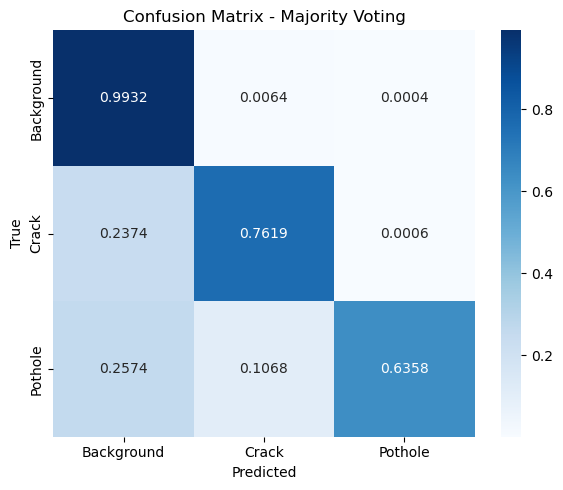

In [10]:
ensemble_majority_voting_eval(test_loader, unet, segformer, visualize=True, num_visuals=3)

## Area Extraction

In [15]:
import csv
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
import numpy as np

@torch.no_grad()
def save_pixel_counts_csv(dataloader, unet, segformer, output_csv_path="ensemble_pixel_counts.csv"):
    unet.eval()
    segformer.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    per_image_pixel_counts = []

    for batch_idx, (images, masks) in enumerate(tqdm(dataloader, desc="🧮 Counting Pixels")):
        for i in range(images.size(0)):
            image_tensor = images[i].cpu()
            global_idx = batch_idx * dataloader.batch_size + i
            filename = dataloader.dataset.filenames[global_idx]

            # Convert to PIL
            pil_img = transforms.ToPILImage()(image_tensor)

            # --- UNet
            w, h = pil_img.size
            if h < 640:
                pad_h = 640 - h
                pad_top = pad_h // 2
                pad_bottom = pad_h - pad_top
                padded_unet = transforms.functional.pad(pil_img, (0, pad_top, 0, pad_bottom), fill=0)
            else:
                padded_unet = pil_img
            img_unet = transforms.functional.to_tensor(padded_unet).unsqueeze(0).to(device)

            # --- SegFormer
            transform_segformer = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
            ])
            img_segformer = transform_segformer(pil_img).unsqueeze(0).to(device)

            # --- Predict
            out_unet = unet(img_unet)
            prob_unet = F.softmax(out_unet, dim=1)

            out_segformer = segformer(pixel_values=img_segformer).logits
            out_segformer = F.interpolate(out_segformer, size=(640, 1024), mode='bilinear', align_corners=False)
            prob_segformer = F.softmax(out_segformer, dim=1)

            # --- Average predictions
            avg_prob = (prob_unet + prob_segformer) / 2
            pred_mask = torch.argmax(avg_prob, dim=1).squeeze(0).cpu().numpy()

            # Count pixels
            crack_pixels = int(np.sum(pred_mask == 1))
            pothole_pixels = int(np.sum(pred_mask == 2))
            total_damage = crack_pixels + pothole_pixels

            per_image_pixel_counts.append([filename, crack_pixels, pothole_pixels, total_damage])

    # --- Save to CSV
    dir_name = os.path.dirname(output_csv_path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)

    with open(output_csv_path, mode="w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Image Name", "Crack Pixels", "Pothole Pixels", "Total Damage Pixels"])
        writer.writerows(per_image_pixel_counts)

    print(f"\n📁 Results saved to: {output_csv_path}")
    return per_image_pixel_counts

In [16]:
results = save_pixel_counts_csv(test_loader, unet, segformer, output_csv_path="ensemble_pixel_counts.csv")

🧮 Counting Pixels: 100%|████████████████████████████████████████████████████████████| 224/224 [00:26<00:00,  8.50it/s]


📁 Results saved to: ensemble_pixel_counts.csv


## Ensemble Learning (3 Model Combination)